<a href="https://colab.research.google.com/github/matin/garth/blob/main/colabs/stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Garmin stress statistics

## Setup

Start by installing and importing `garth`

In [1]:
%pip install garth >& /dev/null

In [2]:
import garth

Define Garth session location to save and resume sessions

In [3]:
SESSION_PATH = 'drive/MyDrive/garth'

Mount Drive for saving and resuming sessions

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Resume session or login, and make sure to save the garth session for next time

In [5]:
from garth.exc import GarthException
from getpass import getpass
from requests import HTTPError

try:
    garth.resume(SESSION_PATH)
    garth.client.auth_token.refresh()
except (GarthException, HTTPError, FileNotFoundError):
    email = input("Email: ")
    password = getpass("Password: ")
    garth.client.login(email, password)

garth.save(SESSION_PATH)

## Weekly stress

Get the most recent week

In [6]:
garth.WeeklyStress.list()

[WeeklyStress(calendar_date=datetime.date(2023, 7, 22), value=33)]

Get the last two years

In [7]:
weekly_stress = garth.WeeklyStress.list(period=104)

Use pandas and matplotlib to graph

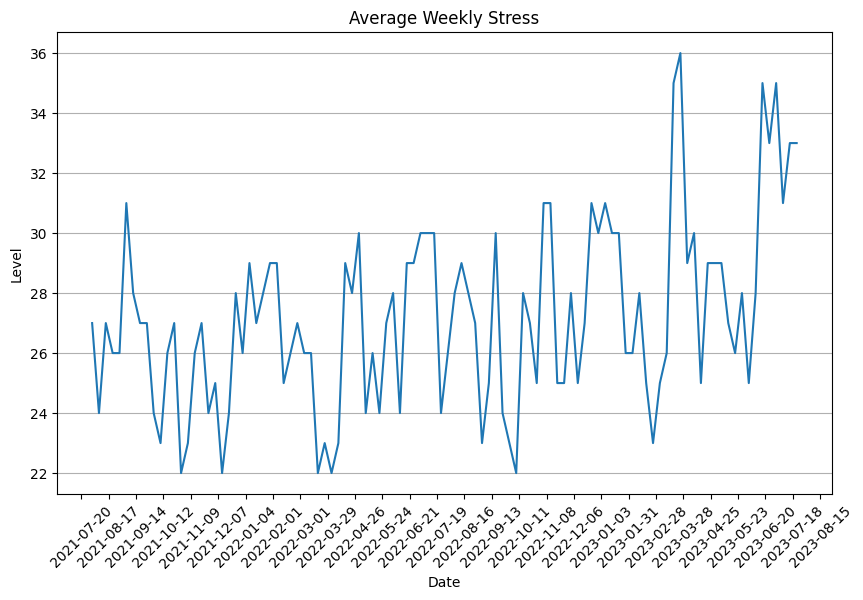

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.DataFrame(weekly_stress).sort_values('calendar_date')

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['calendar_date'], df['value'])
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xlabel('Date')
plt.ylabel('Level')
plt.title('Average Weekly Stress')
plt.grid(True, axis='y')
plt.xticks(rotation=45)
plt.show()

## Daily stress

Retrieve daily averages by week. This takes a while to run.

---



Get yesterday's stress levels

In [9]:
from datetime import date, timedelta

garth.DailyStress.list(date.today() - timedelta(days=1))

[DailyStress(calendar_date=datetime.date(2023, 7, 27), overall_stress_level=44, rest_stress_duration=23280, low_stress_duration=7380, medium_stress_duration=7860, high_stress_duration=11640)]

Get up to the last three years

In [10]:
daily_stress = garth.DailyStress.list(period=365 * 3)

Daily stats are going to have a *lot* of noise, so let's also graph the smoothed 28-day rolling average

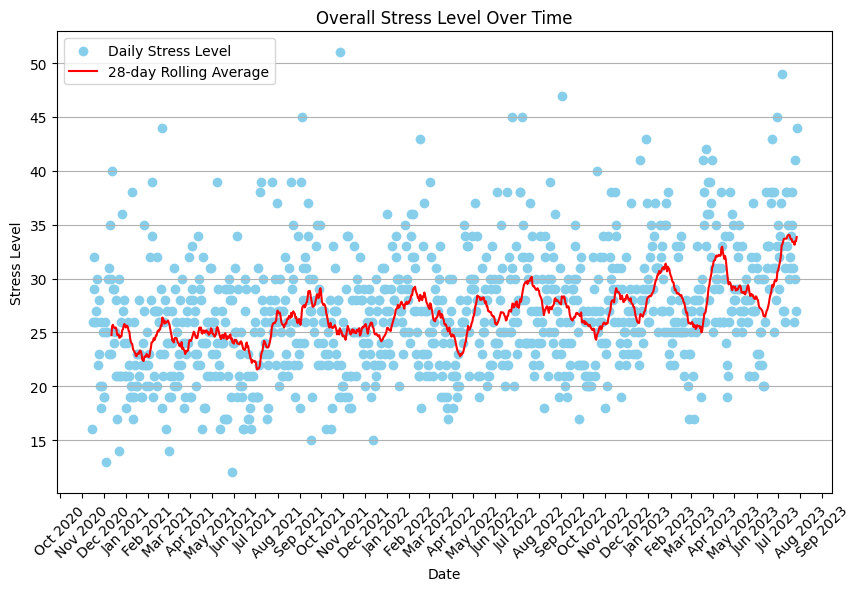

In [11]:
df = pd.DataFrame(daily_stress)
df.set_index('calendar_date', inplace=True)

df['rolling_avg'] = df['overall_stress_level'].rolling(window=28).mean()
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    df.index,
    df['overall_stress_level'],
    color='skyblue',
    label='Daily Stress Level',
)
ax.plot(
    df.index,
    df['rolling_avg'],
    color='r',
    label='28-day Rolling Average',
)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

plt.xlabel('Date')
plt.ylabel('Stress Level')
plt.title('Overall Stress Level Over Time')
plt.grid(True, axis='y')
plt.legend()

plt.xticks(rotation=45)

plt.show()